In [1]:
!pip install colab-ssh --upgrade

from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password='0000')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TensorFlow 설치 (기본적으로 코랩에는 TensorFlow가 설치되어 있지만, 버전 업데이트가 필요할 수 있음)
%pip install tensorflow

# 모델을 사용하기 위한 추가 라이브러리 설치
%pip install h5py

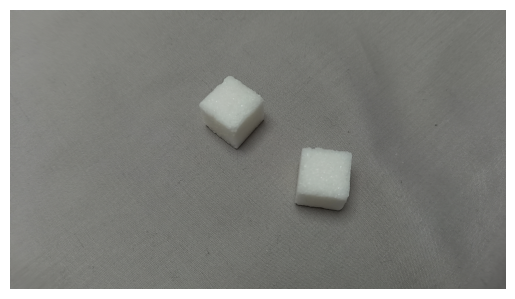

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Image: 52_A01_B01_C010_0000001078.jpg
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Predicted: [('n04372370', 'switch', 0.37554), ('n04116512', 'rubber_eraser', 0.19507383), ('n04074963', 'remote_control', 0.050794616)]
---------------------------------------


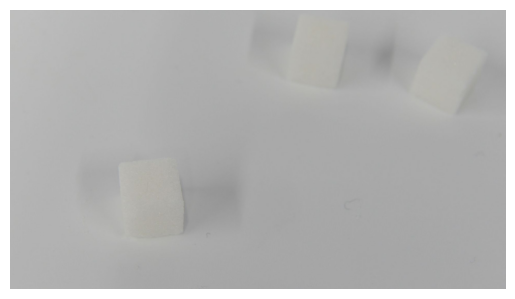

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
Image: 52_A01_B01_C010_0000000031.jpg
Predicted: [('n02786058', 'Band_Aid', 0.9996779), ('n04116512', 'rubber_eraser', 0.0001484358), ('n07615774', 'ice_lolly', 1.5799831e-05)]
---------------------------------------


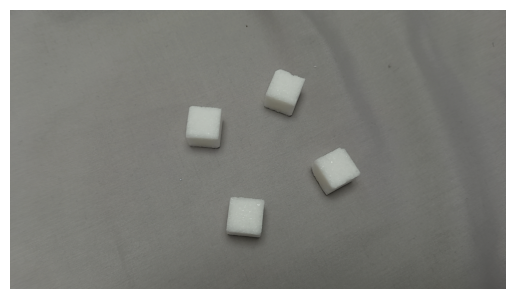

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Image: 52_A01_B01_C010_0000000157.jpg
Predicted: [('n04116512', 'rubber_eraser', 0.3885985), ('n04372370', 'switch', 0.29786897), ('n02786058', 'Band_Aid', 0.033836547)]
---------------------------------------


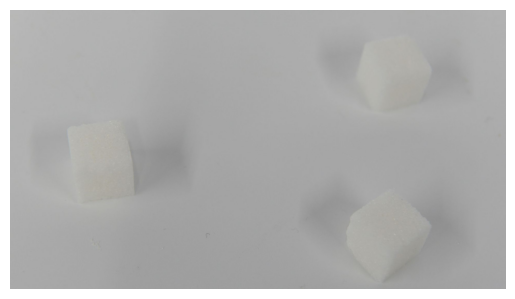

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Image: 52_A01_B01_C010_0000000020.jpg
Predicted: [('n02786058', 'Band_Aid', 0.49504888), ('n04116512', 'rubber_eraser', 0.2651201), ('n04372370', 'switch', 0.08669254)]
---------------------------------------


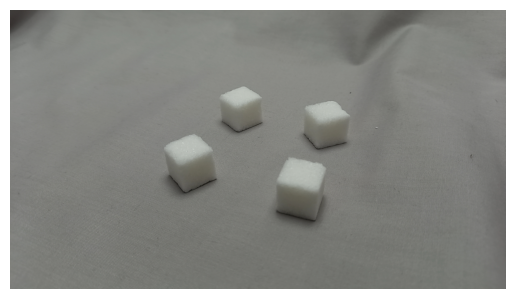

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
Image: 52_A01_B01_C010_0000000178.jpg
Predicted: [('n04074963', 'remote_control', 0.80127734), ('n04372370', 'switch', 0.049280617), ('n07860988', 'dough', 0.0199157)]
---------------------------------------


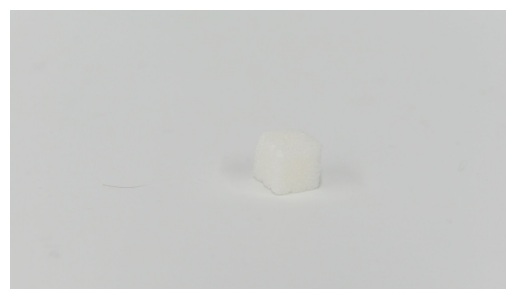

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
Image: 52_A01_B01_C010_0000000009.jpg
Predicted: [('n04116512', 'rubber_eraser', 0.47829613), ('n04372370', 'switch', 0.040154725), ('n02786058', 'Band_Aid', 0.034485765)]
---------------------------------------


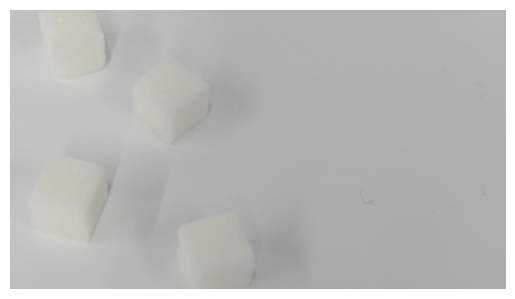

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Image: 52_A01_B01_C010_0000000081.jpg
Predicted: [('n04116512', 'rubber_eraser', 0.5459376), ('n02786058', 'Band_Aid', 0.1964845), ('n07615774', 'ice_lolly', 0.015061376)]
---------------------------------------


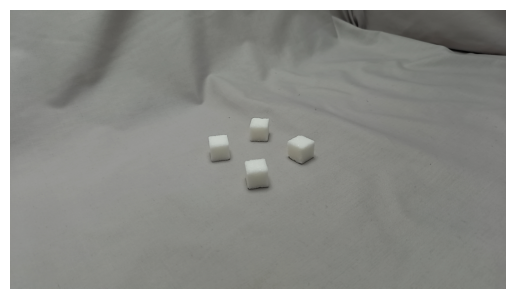

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Image: 52_A01_B01_C010_0000000167.jpg
Predicted: [('n03937543', 'pill_bottle', 0.45195055), ('n07802026', 'hay', 0.21158166), ('n15075141', 'toilet_tissue', 0.04084737)]
---------------------------------------


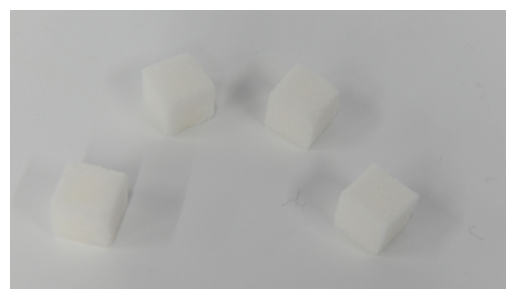

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
Image: 52_A01_B01_C010_0000000052.jpg
Predicted: [('n04116512', 'rubber_eraser', 0.72383183), ('n02786058', 'Band_Aid', 0.026739057), ('n07717556', 'butternut_squash', 0.0059735007)]
---------------------------------------


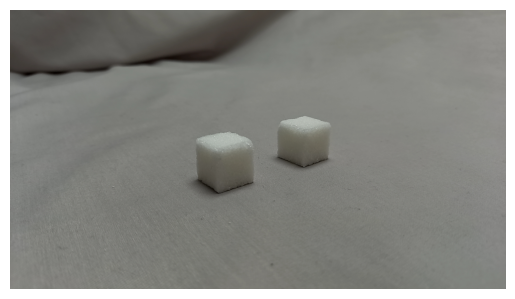

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
Image: 52_A01_B01_C010_0000000071.jpg
Predicted: [('n04116512', 'rubber_eraser', 0.46751404), ('n07860988', 'dough', 0.18671843), ('n04074963', 'remote_control', 0.01642017)]
---------------------------------------


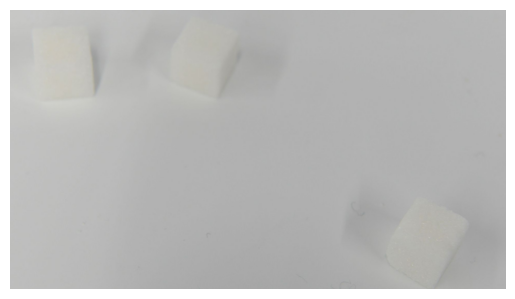

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
Image: 52_A01_B01_C010_0000000060.jpg
Predicted: [('n02786058', 'Band_Aid', 0.99943966), ('n04116512', 'rubber_eraser', 0.0001986954), ('n04372370', 'switch', 0.000102332604)]
---------------------------------------


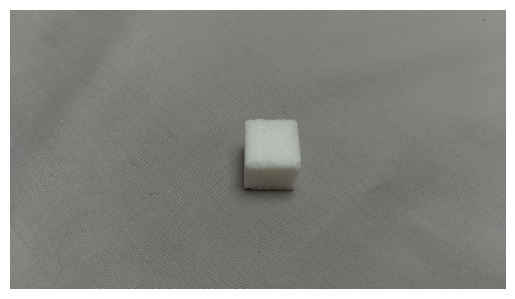

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
Image: 52_A01_B01_C010_0000000124.jpg
Predicted: [('n04372370', 'switch', 0.77130896), ('n04116512', 'rubber_eraser', 0.027273187), ('n15075141', 'toilet_tissue', 0.011066649)]
---------------------------------------


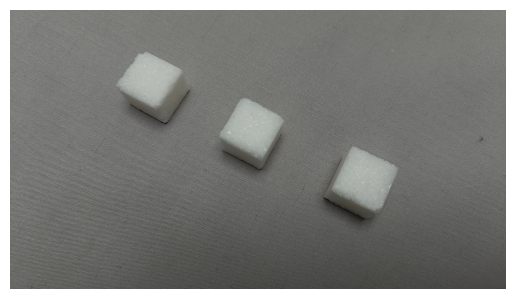

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
Image: 52_A01_B01_C010_0000000135.jpg
Predicted: [('n04372370', 'switch', 0.8844315), ('n04074963', 'remote_control', 0.047008883), ('n04116512', 'rubber_eraser', 0.009450653)]
---------------------------------------


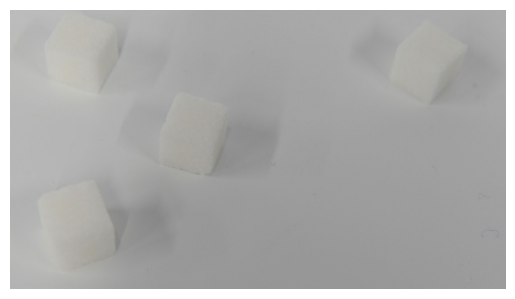

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Image: 52_A01_B01_C010_0000000041.jpg
Predicted: [('n02786058', 'Band_Aid', 0.9501255), ('n04116512', 'rubber_eraser', 0.021595232), ('n07615774', 'ice_lolly', 0.0009282575)]
---------------------------------------


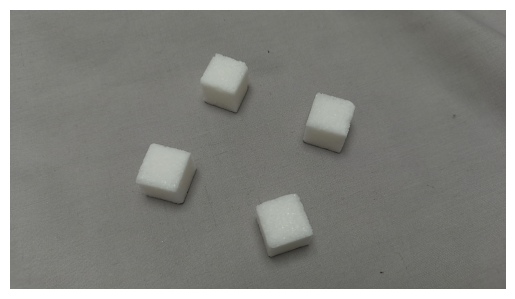

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: 52_A01_B01_C010_0000000200.jpg
Predicted: [('n04372370', 'switch', 0.48814058), ('n04116512', 'rubber_eraser', 0.16995724), ('n04074963', 'remote_control', 0.16775002)]
---------------------------------------


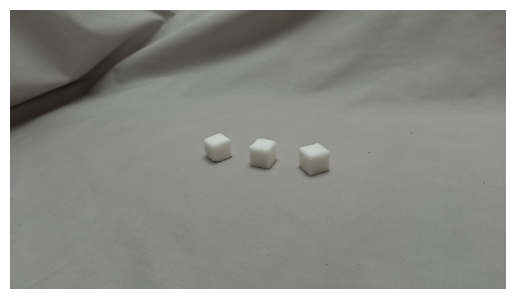

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: 52_A01_B01_C010_0000000552.jpg
Predicted: [('n03937543', 'pill_bottle', 0.79426175), ('n03690938', 'lotion', 0.04891879), ('n12144580', 'corn', 0.012995894)]
---------------------------------------


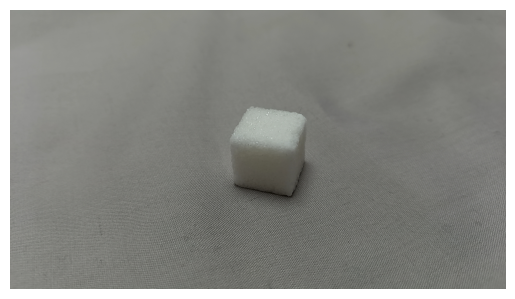

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
Image: 52_A01_B01_C010_0000000114.jpg
Predicted: [('n04116512', 'rubber_eraser', 0.42028627), ('n04372370', 'switch', 0.21574576), ('n07860988', 'dough', 0.02449267)]
---------------------------------------


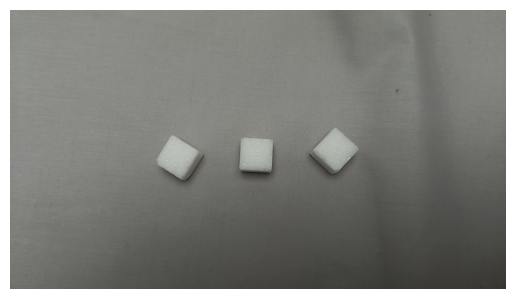

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
Image: 52_A01_B01_C010_0000000573.jpg
Predicted: [('n02786058', 'Band_Aid', 0.532941), ('n04116512', 'rubber_eraser', 0.13313769), ('n04372370', 'switch', 0.12896945)]
---------------------------------------


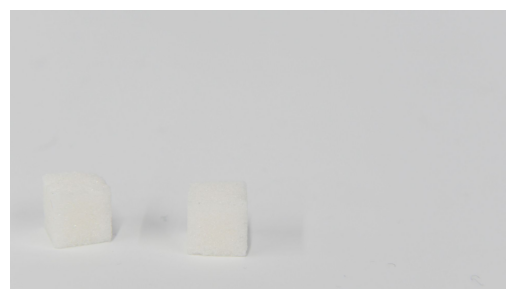

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Image: 52_A01_B01_C010_0000000211.jpg
Predicted: [('n04116512', 'rubber_eraser', 0.8707689), ('n03729826', 'matchstick', 0.016250597), ('n02786058', 'Band_Aid', 0.007998176)]
---------------------------------------


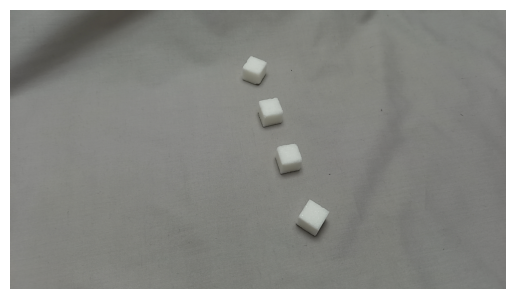

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
Image: 52_A01_B01_C010_0000000498.jpg
Predicted: [('n07802026', 'hay', 0.48576328), ('n04372370', 'switch', 0.16387938), ('n15075141', 'toilet_tissue', 0.09107119)]
---------------------------------------


In [ ]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions


# Inception-ResNet-V2 모델 로드 (사전 학습된 가중치 사용)
model = InceptionResNetV2(weights='imagenet')

# 이미지가 저장된 로컬 폴더 경로
image_folder_path = os.path.join(os.getcwd(), '../../datasets/Validation/normal')

# 이미지 파일 목록 가져오기
if not os.path.exists(image_folder_path):
    print(f"Error: The path '{image_folder_path}' does not exist.")
else:
    image_files = [f for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]

    # 이미지 파일 목록에서 처음 20개만 선택
    first_twenty_images = image_files[:20]

    # 각 이미지에 대해 예측 수행
    for image_file in first_twenty_images:
        try:
            img_path = os.path.join(image_folder_path, image_file)
            img = Image.open(img_path)  # 이미지 열기
            plt.imshow(img)  # 이미지 표시
            plt.axis('off')  # 축 제거
            plt.show()  # 이미지 출력

            # 모델이 기대하는 입력 크기로 이미지 로드
            img = image.load_img(img_path, target_size=(299, 299))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            # 모델을 사용하여 예측
            preds = model.predict(x)

            # 예측 결과 디코딩 및 출력
            print(f'Image: {image_file}')
            print('Predicted:', decode_predictions(preds, top=3)[0])
            print('---------------------------------------')

        except Exception as e:
            print(f"Error processing {image_file}: {e}")